<a href="https://www.kaggle.com/code/mikedelong/treemaps-for-trees?scriptVersionId=139645202" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from glob import glob
from pandas import concat
from pandas import read_csv

df = concat([read_csv(filepath_or_buffer=input_file, parse_dates=['most_recent_observation', 'planted_date', 'retired_date'],
                      low_memory=False,) for input_file in glob('/kaggle/input/5m-trees-dataset/*Final*.csv')])
df['genus'] = df['scientific_name'].apply(func=lambda x: x if not isinstance(x, str) else x.split()[0])
df['species'] = df['scientific_name'].apply(func=lambda x: x if (not isinstance(x, str) or len(x.split()) > 1) else ' '.join(x.split()[1:]))
# expect (5660237, 30)
print(df.shape)

(5660237, 30)


In [2]:
df.columns

Index(['most_recent_observation', 'most_recent_observation_type',
       'common_name', 'scientific_name', 'city', 'state',
       'longitude_coordinate', 'latitude_coordinate', 'location_name',
       'diameter_breast_height_CM', 'height_M', 'native', 'height_binned_M',
       'diameter_breast_height_binned_CM', 'greater_metro', 'city_ID',
       'tree_ID', 'planted_date', 'retired_date', 'location_type', 'zipcode',
       'address', 'neighborhood', 'ward', 'district', 'overhead_utility',
       'condition', 'percent_population', 'genus', 'species'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5660237 entries, 0 to 17521
Data columns (total 30 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   most_recent_observation           object        
 1   most_recent_observation_type      object        
 2   common_name                       object        
 3   scientific_name                   object        
 4   city                              object        
 5   state                             object        
 6   longitude_coordinate              float64       
 7   latitude_coordinate               float64       
 8   location_name                     object        
 9   diameter_breast_height_CM         float64       
 10  height_M                          float64       
 11  native                            object        
 12  height_binned_M                   object        
 13  diameter_breast_height_binned_CM  object        
 14  greater_metro       

<Axes: >

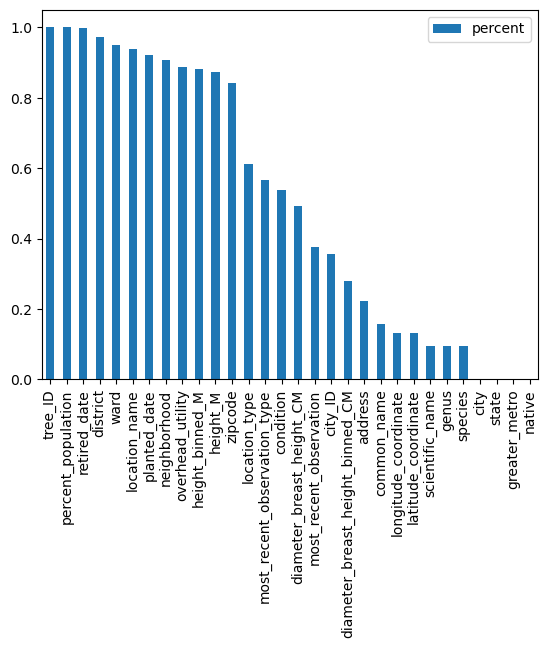

In [4]:
# info() doesn't return our isna counts, so we need to get them
isna_df = df.isna().sum().to_frame()
isna_df['percent'] = isna_df[0]/len(df)
isna_df.sort_values(ascending=False, by='percent')[['percent']].plot(kind='bar')

We really need an interactive widget to be able to understand much about this data. Let's try to look at the state and city data first.

In [5]:
from plotly.express import treemap
state_city = ['state', 'city']
treemap(data_frame=df.groupby(by=state_city).size().reset_index(), path=state_city, values=0).show()

We can similarly combine the state with the scientific name data; trying to cmbine it with the city data (too) might be a bit much. 

In [6]:
from plotly.express import treemap
state_species = ['state', 'genus', 'species']
treemap(data_frame=df.groupby(by=state_species).size().reset_index(), path=state_species, values=0).show()

In [7]:
# how many states do we have data for?
df['state'].nunique()

33

In [8]:
import plotly.express as px
state_genus = ['state', 'genus']
state_genus_df = df[state_genus].groupby(state_genus).size().sort_values(ascending=False).reset_index().drop_duplicates(subset='state')
# we need to add in state abbreviations to get the choropleth to work
state_abbrev_df = state_abbrev_df = read_csv(filepath_or_buffer='/kaggle/input/state-abbreviations/state_abbrev.csv', usecols=['State', 'Abbreviation'])
state_genus_df = state_genus_df.merge(right=state_abbrev_df, right_on='State', left_on='state').drop(columns=['State'])

px.choropleth(locationmode='USA-states', scope='usa', data_frame=state_genus_df, locations = 'Abbreviation',  color='genus',).show()